코드 정리는 아직 못해서 지저분할 수 있습니다..!

## 0. 데이터 불러오기

### 0.1. 기본 설정

In [1]:
from typing import Union, Tuple, List

import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy import sparse
import bottleneck as bn
from sklearn.decomposition import PCA
import torch



In [3]:
from implicit.evaluation import  *
from implicit.als import AlternatingLeastSquares as ALS

In [4]:
raw_data=  pd.read_csv('./data/train/train_ratings.csv')
DATA_DIR= './data/train'

### 0.2. random seed 고정

In [5]:
seed = 0

random.seed(seed)
np.random.seed(seed)

## 1. train, val, test set만들기

In [6]:
#훈련된 모델을 이용해 검증할 데이터를 분리하는 함수입니다.
#100개의 액션이 있다면, 그중에 test_prop 비율 만큼을 비워두고, 그것을 모델이 예측할 수 있는지를
#확인하기 위함입니다.
def split_train_test_proportion(data, test_prop=0.2): #원래 0.2
    data_grouped_by_user = data.groupby('user')
    tr_list, te_list = list(), list()

    np.random.seed(98765)
    
    for _, group in data_grouped_by_user:
        n_items_u = len(group)
        
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        
        else:
            tr_list.append(group)
    
    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

def numerize(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [7]:
# Shuffle User Indices
unique_uid = raw_data.user.unique()
print("(BEFORE) unique_uid:",unique_uid)
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
print("(AFTER) unique_uid:",unique_uid)

n_users = unique_uid.size #31360
n_heldout_users = 3136#3000


# Split Train/Validation/Test User Indices
tr_users = unique_uid[:]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

#주의: 데이터의 수가 아닌 사용자의 수입니다!
print("훈련 데이터에 사용될 사용자 수:", len(tr_users))
print("검증 데이터에 사용될 사용자 수:", len(vd_users))
print("테스트 데이터에 사용될 사용자 수:", len(te_users))

(BEFORE) unique_uid: [    11     14     18 ... 138486 138492 138493]
(AFTER) unique_uid: [27968 67764  2581 ... 41891 15720 17029]
훈련 데이터에 사용될 사용자 수: 31360
검증 데이터에 사용될 사용자 수: 3136
테스트 데이터에 사용될 사용자 수: 3136


In [8]:
##아이템 ID
unique_sid = pd.unique(raw_data['item'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))

profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [286]:
import pickle
with open('show2id.pkl','wb') as f:
    pickle.dump(show2id,f)
with open('profile2id.pkl','wb') as f:
    pickle.dump(profile2id,f)

In [285]:
show2id

{4643: 0,
 170: 1,
 531: 2,
 616: 3,
 2140: 4,
 2722: 5,
 2313: 6,
 2688: 7,
 2428: 8,
 3113: 9,
 1591: 10,
 2600: 11,
 8169: 12,
 2572: 13,
 58293: 14,
 7541: 15,
 1367: 16,
 32: 17,
 4792: 18,
 7444: 19,
 53953: 20,
 56949: 21,
 6502: 22,
 53000: 23,
 51662: 24,
 5151: 25,
 35836: 26,
 7293: 27,
 33585: 28,
 8810: 29,
 56801: 30,
 5377: 31,
 344: 32,
 19: 33,
 410: 34,
 2124: 35,
 828: 36,
 1274: 37,
 8977: 38,
 1032: 39,
 1214: 40,
 1200: 41,
 1320: 42,
 3897: 43,
 7173: 44,
 1225: 45,
 2858: 46,
 59418: 47,
 45361: 48,
 2706: 49,
 1321: 50,
 2793: 51,
 33085: 52,
 4235: 53,
 3892: 54,
 4340: 55,
 27660: 56,
 43556: 57,
 47124: 58,
 2294: 59,
 48304: 60,
 150: 61,
 31184: 62,
 34338: 63,
 1917: 64,
 50162: 65,
 2827: 66,
 27368: 67,
 4366: 68,
 2153: 69,
 30812: 70,
 3525: 71,
 1270: 72,
 2011: 73,
 2012: 74,
 8973: 75,
 1255: 76,
 2018: 77,
 541: 78,
 4878: 79,
 7361: 80,
 31658: 81,
 2571: 82,
 7099: 83,
 260: 84,
 1196: 85,
 60069: 86,
 160: 87,
 1882: 88,
 60037: 89,
 880: 90,
 

In [9]:
# ##훈련 데이터에 해당하는 아이템들
# #Train에는 전체 데이터를 사용합니다.
# train_plays = raw_data.loc[raw_data['user'].isin(tr_users)]
# train_plays  = train_plays.loc[train_plays['item'].isin(unique_sid)]
# train_plays_tr, train_plays_te = split_train_test_proportion(train_plays)


# #Validation과 Test에는 input으로 사용될 tr 데이터와 정답을 확인하기 위한 te 데이터로 분리되었습니다.
# vad_plays = raw_data.loc[raw_data['user'].isin(vd_users)]
# vad_plays = vad_plays.loc[vad_plays['item'].isin(unique_sid)]
# vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

# test_plays = raw_data.loc[raw_data['user'].isin(te_users)]
# test_plays = test_plays.loc[test_plays['item'].isin(unique_sid)]
# test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)



# train_data_tr = numerize(train_plays_tr, profile2id, show2id)
# train_data_tr.to_csv(os.path.join(pro_dir, 'train_tr.csv'), index=False)

# train_data_te = numerize(train_plays_te, profile2id, show2id)
# train_data_te.to_csv(os.path.join(pro_dir, 'train_te.csv'), index=False)

# vad_data_tr = numerize(vad_plays_tr, profile2id, show2id)
# vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

# vad_data_te = numerize(vad_plays_te, profile2id, show2id)
# vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

# test_data_tr = numerize(test_plays_tr, profile2id, show2id)
# test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

# test_data_te = numerize(test_plays_te, profile2id, show2id)
# test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

print("Done!")

Done!


In [10]:
class DataLoader():
    '''
    Load Movielens dataset
    '''
    def __init__(self, path):
        
        self.pro_dir = os.path.join(path, 'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files do not exist. Run data.py"

        self.n_items = self.load_n_items()
    
    def load_data(self, datatype='train'):
        if datatype == 'train':
            return self._load_tr_te_data(datatype)
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype)
        else:
            raise ValueError("datatype should be in [train, validation, test]")
        
    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items
    
    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')
        
        tp = pd.read_csv(path)
        n_users = tp['uid'].max() + 1

        rows, cols = tp['uid'], tp['sid']
        data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, self.n_items))

    
        return data
    
    def _load_tr_te_data(self, datatype='test'):
        tr_path = os.path.join(self.pro_dir, '{}_tr.csv'.format(datatype))
        te_path = os.path.join(self.pro_dir, '{}_te.csv'.format(datatype))

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)

        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

        rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
        rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

        data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))

        return data_tr, data_te

In [11]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):    
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)

    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

## 2. ALS 기반 MF 모델 실습

In [12]:
loader = DataLoader(DATA_DIR)

n_items = loader.load_n_items()
train_data_tr, train_data_te = loader.load_data('train')
# vad_data_tr, vad_data_te = loader.load_data('validation')
# test_data_tr, test_data_te = loader.load_data('test')

In [13]:
train_data_tr

<31360x6807 sparse matrix of type '<class 'numpy.float64'>'
	with 4136075 stored elements in Compressed Sparse Row format>

In [201]:
def numerize_for_infer(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

### 데이터 준비    
infer_df = numerize_for_infer(raw_data, profile2id, show2id)

loader = DataLoader(DATA_DIR)
n_items = loader.load_n_items()

n_users = infer_df['uid'].max() + 1

rows, cols = infer_df['uid'], infer_df['sid']
data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, n_items))

N = data.shape[0]
idxlist = list(range(N))


In [202]:
infer_df

,uid,sid
0,11825,0
1,11825,1
2,11825,2
3,11825,3
4,11825,4
...,...,...
5154466,10783,423
5154467,10783,1491
5154468,10783,331
5154469,10783,733


In [157]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, random_state=seed)
als_model.fit(train_data_tr)
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 
print(np.mean(Recall_at_k_batch(x_pred, train_data_te, k=10)))

  0%|          | 0/50 [00:00<?, ?it/s]

0.12914034661483642


In [ ]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, random_state=seed)
als_model.fit(vad_data_tr)
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 
print(np.mean(Recall_at_k_batch(x_pred, vad_data_te, k=10)))

In [ ]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, random_state=seed)
als_model.fit(test_data_tr)
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 
print(np.mean(Recall_at_k_batch(x_pred, test_data_te, k=10)))

### 2.1.1 most popular 가중치 적용해보기

In [18]:
temp= als_model.item_factors.to_numpy()
temp.shape

(6807, 7)

In [19]:
popular=np.array([infer_df.groupby('sid')['uid'].count()/10])
popular=popular.T

In [ ]:
popular= np.tile(popular, [1, 7])


In [ ]:
pop_item= popular * temp
x_pred= np.dot(als_model.user_factors.to_numpy(), pop_item.T) 
print(np.mean(Recall_at_k_batch(x_pred, test_data_te, k=10)))

 -> 단순히 인기도를 곱하는 것만으론 좋은 성능이 나오지 않는다.

### 2.1.2. item 워드임베딩 적용해보기
워드 임베딩을 als latent factor 초기 값으로 사용

In [ ]:
# sasrec= torch.load("./code/output/sas_wandb-Ml.pt")

In [ ]:
# temp_emb= sasrec['item_embeddings.weight']
# temp_emb.size()

In [185]:
pretrain= torch.load("./code/output/Pretrain.pt")
temp_emb=pretrain['item_embeddings.weight']

del pretrain

In [186]:
# 영화 ID를 기준으로 임베딩이 설정되어있기 때문에 6807로 수정할 필요가 있다. 
# 0은 패딩인덱스, 맨 뒤에는 마스크이므로 뺀다.

item_emb= temp_emb[1:-1,:]
item_emb.shape

del temp_emb

In [187]:
item_df= pd.DataFrame(item_emb.cpu())
item_df.index = item_df.index+1
item_df.reset_index(inplace=True)

del item_emb

In [188]:
def match_idx(x):
    try:
        return show2id[x]
    except KeyError:
        return -1000

In [189]:
item_df['index']= item_df['index'].apply(lambda x: match_idx(x))

In [190]:
item_df= item_df[item_df['index']!=-1000]
item_df.sort_values('index', inplace=True)

In [191]:
item_df=item_df.loc[:,0:] 
item_np= np.asarray(item_df)

del item_df

In [192]:

pca =  PCA(n_components = 7, random_state=seed)
item_np = item_np - np.mean(item_np)
item_fit = pca.fit_transform(item_np)

del item_np

In [242]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, random_state=seed, item_emb= item_fit/100)
als_model.fit(train_data_tr)
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 
print(np.mean(Recall_at_k_batch(x_pred, train_data_te, k=10)))

  0%|          | 0/50 [00:00<?, ?it/s]

0.1291371578393262


In [ ]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, random_state=seed,item_emb= item_fit/100)
als_model.fit(vad_data_tr)
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 
print(np.mean(Recall_at_k_batch(x_pred, vad_data_te, k=10)))

In [ ]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, random_state=seed,item_emb= item_fit/100)
als_model.fit(test_data_tr)
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 
print(np.mean(Recall_at_k_batch(x_pred, test_data_te, k=10)))

-> 0.0001성능향상이 있었습니다.

### 2.1.3 장르 선호도 반영하기

In [ ]:
lst= np.load("./data/train/lst.npy")

In [281]:
print(np.mean(Recall_at_k_batch(x_pred+lst/100, train_data_te, k=10)))

0.12941232891966312


-> 0.0004 성능향상이 있었습니다.

# 3. Submission 

In [203]:
check= infer_df.copy()
check['exist']= 1
check= check.pivot_table('exist','uid','sid')
check.fillna(0, inplace=True)
check

sid,0,1,2,3,4,5,6,7,8,9,...,6797,6798,6799,6800,6801,6802,6803,6804,6805,6806
uid,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31357,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
als_model = ALS(factors=7, regularization=0.01, iterations = 50, item_emb= item_fit/100, random_state=seed)
als_model.fit(data)
emb_item= als_model.item_factors.to_numpy()
x_pred= np.dot(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T) 

  0%|          | 0/50 [00:00<?, ?it/s]

In [227]:
x_pred= x_pred+lst/100

In [228]:
check[0][1000:2000]

uid
1000    0.0
1001    0.0
1002    0.0
1003    0.0
1004    1.0
       ... 
1995    0.0
1996    1.0
1997    0.0
1998    0.0
1999    0.0
Name: 0, Length: 1000, dtype: float64

In [229]:
df= pd.DataFrame(x_pred)
df[0][1000:2000]

1000    0.056746
1001    0.033926
1002    0.034190
1003    0.066428
1004    0.192595
          ...   
1995    0.031946
1996    0.083240
1997    0.051998
1998    0.029184
1999    0.040975
Name: 0, Length: 1000, dtype: float32

In [230]:
x_pred[data.toarray() > 0] = -np.inf

In [231]:
idx= np.argsort(-x_pred)[:,:10]

In [232]:
idx

array([[ 604,  359,  844, ...,  265,  507,  202],
       [ 159,  160,   40, ...,   78,  144,  162],
       [ 264,  742,   80, ...,  601,  598,  760],
       ...,
       [  80,  264,   78, ...,  601,  730,  341],
       [  46,  312,  341, ..., 2697,  840,  299],
       [ 209,  297,  374, ...,  202,  218,  373]])

In [235]:
### sample_submission 형태로 바꾸고 id 다시 바꾸기
user = []
item = []
for i_idx, arr_10 in enumerate(idx):
    user.extend([i_idx]*10)
    item.extend(arr_10)

u = pd.DataFrame(user, columns=['user'])
i = pd.DataFrame(item, columns=['item'])
all = pd.concat([u, i], axis=1)

In [236]:
all

,user,item
0,0,604
1,0,359
2,0,844
3,0,858
4,0,751
...,...,...
313595,31359,211
313596,31359,203
313597,31359,202
313598,31359,218


In [237]:
def de_numerize(tp, re_p2id, re_s2id):
    uid = tp['user'].apply(lambda x: re_p2id[x])
    sid = tp['item'].apply(lambda x: re_s2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

ans = de_numerize(all, re_p2id, re_s2id)
ans.columns = ['user', 'item']
new_ans = ans.sort_values('user')
new_ans.reset_index(drop=True, inplace=True)

In [238]:
new_ans

,user,item
0,11,40815
1,11,4886
2,11,8961
3,11,32587
4,11,4963
...,...,...
313595,138493,8368
313596,138493,33794
313597,138493,8874
313598,138493,8961


In [239]:
new_ans.to_csv("/opt/ml/input/code/output/answer/als_genre.csv", index=False)

# 4. Model output 비교

In [252]:
als_genre= pd.read_csv("/opt/ml/input/code/output/answer/als_genre.csv")
als=  pd.read_csv("/opt/ml/input/code/output/answer/als.csv")

In [273]:
als_genre[als_genre['user']==138493]

,user,item
313590,138493,1270
313591,138493,5349
313592,138493,1197
313593,138493,2762
313594,138493,551
313595,138493,8368
313596,138493,33794
313597,138493,8874
313598,138493,8961
313599,138493,4878


In [275]:
als[als['user']==138493]

,user,item
313590,138493,1270
313591,138493,5349
313592,138493,1197
313593,138493,551
313594,138493,8368
313595,138493,2762
313596,138493,33794
313597,138493,8874
313598,138493,8961
313599,138493,4878


In [255]:
als_genre['user'].unique()

array([    11,     14,     18, ..., 138486, 138492, 138493])

In [260]:
df=pd.DataFrame(data={'user': als_genre['user'].unique()})

In [253]:
als_genre.drop_duplicates('user', keep='first')

,user,item
0,11,40815
1,11,4886
2,11,8961
3,11,32587
4,11,4963
...,...,...
313595,138493,8368
313596,138493,33794
313597,138493,8874
313598,138493,8961


### 기존 일부 유저-아이템 rating 매트릭스


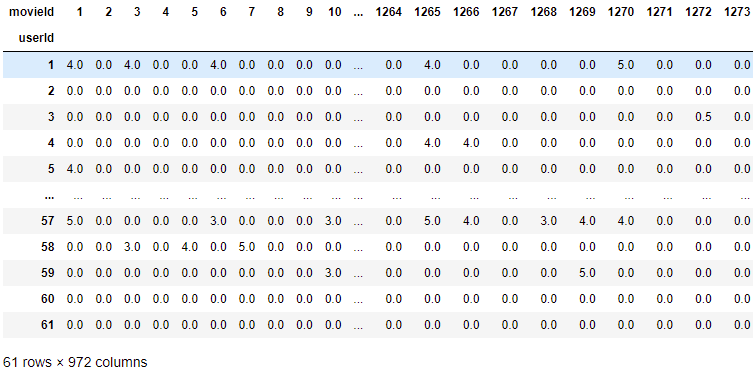

### 예측된 유저-아이템 preference 매트릭스

- 아래와 동일한 결과가 나와야 함

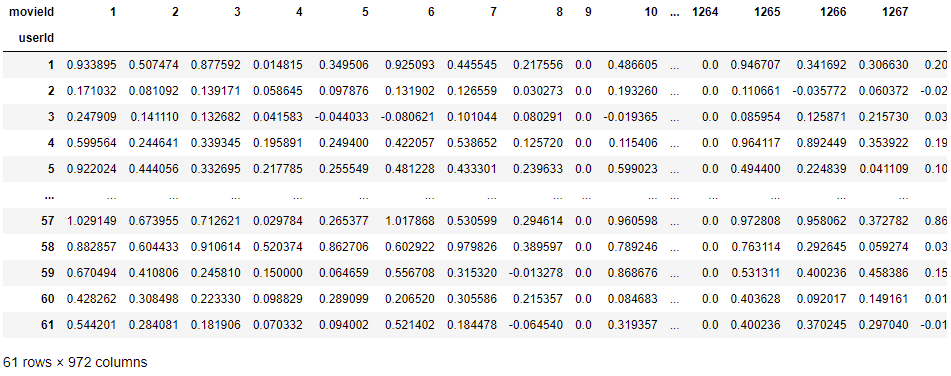